In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import zipfile
import os
import numpy as np

# extracted_dir = '/content/drive/MyDrive/IA/Mariposas_images'
extracted_dir = '/home/squispeb/university/ML-Classification-p/mariposasimg'

if not (os.path.exists(extracted_dir) and os.path.isdir(extracted_dir)):
  zip_file_path = '/home/squispeb/university/ML-Classification-p/Mariposas.zip'
  print(zip_file_path)
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extracted_dir)
  print("Everything extracted")
else:
  print("Everything already extracted")

/home/squispeb/university/ML-Classification-p/Mariposas.zip
Everything extracted


In [82]:
import os
import numpy as np
from PIL import Image
import pywt
import pywt.data

images_dir = extracted_dir + "/images"
file_list = os.listdir(images_dir)

newy = 64
newx = 128

new_images_path = extracted_dir + "/images" + str(newx) + "x" + str(newy)
if not os.path.exists(new_images_path):
  os.makedirs(new_images_path)

  for filename in file_list:
    if filename.endswith(('.jpg', '.png', '.jpeg', '.gif', '.bmp')):


        image_path = os.path.join(images_dir, filename)

        image = Image.open(image_path)
        resized_image = image.resize((newx, newy))


        resized_image.save( new_images_path + "/" + filename)
        resized_image.close()
        image.close()

Y = []
X = []
for filename in file_list:
  if filename.endswith(('.jpg', '.png', '.jpeg', '.gif', '.bmp')):
    Y.append([int(filename[0:3])])
    image_path = os.path.join(new_images_path, filename)
    image = Image.open(image_path)
    image = image.convert('L')
    wavelet = 'haar'  # Puedes cambiar la wavelet según tus necesidades
    coeffs = pywt.dwt2(image, wavelet)
    approximation, (horizontal_detail, vertical_detail, diagonal_detail) = coeffs
    vector_caracteristico = approximation.flatten()
    X.append(vector_caracteristico)

X = np.array(X)
print(X.shape)
Y = np.array(Y)
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=50)

# Ajustar PCA a tus datos.
X = pca.fit_transform(X)

# 'X_transformed' contiene los datos transformados con PCA y reducidos a 'n_components' dimensiones.

# Si deseas saber cuánta varianza explican tus componentes principales, puedes acceder a la información de varianza.
#explained_variance = pca.explained_variance_ratio_
# print("Varianza explicada por cada componente:", explained_variance)
#print(X.shape)


(832, 2048)


In [83]:
import numpy as np

# Convert X and Y to numpy arrays
# X = np.array(X)
# Y = np.array(Y)

# Print the shapes of X and Y



dataset = np.concatenate((X, Y.reshape(-1, 1)), axis=1)
# Print the first 5 rows of X and Y
X, Y = dataset[:,:-1], dataset[:,-1]

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (832, 50)
Y shape: (832,)


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=41)

In [3]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value

In [4]:
import multiprocessing

class DT():
    def __init__(self):
        self.root = None

    def build_tree(self, dataset):

        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)

        if not self.IsTerminal(Y):
            best_split = self.BestSplit(dataset, num_samples, num_features)

            left_subtree = self.build_tree(best_split["dataset_left"])
            right_subtree = self.build_tree(best_split["dataset_right"])
            return Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["info_gain"])

        leaf_value = Y[0]
        return Node(value=leaf_value, info_gain=0)

    def IsTerminal(self, Y):
      return np.all(Y == Y[0])

    def BestSplit(self, dataset, num_samples, num_features):

        best_split = {}
        max_info_gain = -float("inf")

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            threshold = np.median(possible_thresholds)
            dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
            if len(dataset_left)>0 and len(dataset_right)>0:
                y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                if curr_info_gain>max_info_gain:
                    best_split["feature_index"] = feature_index
                    best_split["threshold"] = threshold
                    best_split["dataset_left"] = dataset_left
                    best_split["dataset_right"] = dataset_right
                    best_split["info_gain"] = curr_info_gain
                    max_info_gain = curr_info_gain

        return best_split

    def split(self, dataset, feature_index, threshold):

      sorted_dataset = dataset[np.argsort(dataset[:, feature_index])]
      split_index = np.searchsorted(sorted_dataset[:, feature_index], threshold)

      dataset_left = sorted_dataset[:split_index]
      dataset_right = sorted_dataset[split_index:]
      return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="entropy"):

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.Gini(parent) - (weight_l*self.Gini(l_child) + weight_r*self.Gini(r_child))
        else:
            gain = self.Entropy(parent) - (weight_l*self.Entropy(l_child) + weight_r*self.Entropy(r_child))
        return gain

    def Entropy(self, y):

      class_labels = np.unique(y)
      entropy = 0
      for cls in class_labels:
        p_cls = len(y[y == cls]) / len(y)
        entropy += -p_cls * np.log2(p_cls)
      return entropy

    def Gini(self, y):

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini

    def fit(self, X, Y):

        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, x):

        predition = self.make_prediction(x, self.root)
        return predition

    def make_prediction(self, x, tree):

        if tree.value!=None:
          return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)



In [84]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class LinearRegression():
    def __init__(self):
        self.w = None
        self.b = None
        self.L = None

    def h(self, x):
        """
        x: vector de caracteristicas
        """
        return np.dot(x, self.w)

    def LossFunction(self, x, y):
        """
        X: vector de caracteristicas
        Y: vector de etiquetas
        """
        n = len(x)
        loss = np.sum((self.h(x) - y) ** 2) / (2 * n)
        return loss

    def Derivatives(self, x, y):
        """
        x: vector de caracteristicas
        y: vector de etiquetas
        """
        n = len(x)
        dw = np.dot(x.T, (self.h(x) - y)) / n
        db = np.sum(self.h(x) - y) / n
        return dw, db

    def ChangeParameters(self, x, y, alpha):
        """
        x: vector de caracteristicas
        y: vector de etiquetas
        learning_rate: tasa de aprendizaje
        """
        dw, db = self.Derivatives(x, y)
        self.w -= alpha * dw
        self.b -= alpha * db

    def Training(self, x, y, epochs=100, alpha=0.01):
        """
        x: vector de caracteristicas
        y: vector de etiquetas
        epochs: numero de iteraciones
        """
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=41)
        self.w = np.random.random(x.shape[1])
        self.b = 0
        for i in range(epochs):
            self.L = self.LossFunction(x_train, y_train)
            dw, db = self.Derivatives(x_train, y_train)
            self.w -= alpha * dw
            self.b -= alpha * db
        test_loss = self.LossFunction(x_test, y_test)
        return self.L, test_loss

    def Testing(self, x):
        """
        x: vector de caracteristicas
        """
        y_pred = self.h(x)
        return y_pred

    def Graph(self, x, y):
        """
        x: vector de caracteristicas
        y: vector de etiquetas
        """
        plt.scatter(x, y)
        plt.plot(x, self.h(x), color='red')
        plt.show()

       


In [88]:
from cvxopt import matrix, solvers


class SuperVectorMachine:
    def __init__(self):
        self.w = None
        self.b = None
        self.lambda_list = None
        self.X = None
        self.Y = None

    def GetLambda(self):
        X = self.X  # Asegúrate de que X y Y estén definidos en tu instancia
        Y = self.Y

        K = np.dot(X, X.T) * np.dot(Y, Y.T)
        P = matrix(K)
        q = matrix(-np.ones((len(X), 1)))
        G = matrix(-np.eye(len(X)))
        h = matrix(np.zeros(len(X)))

        # A debe ser una matriz con una fila y el número correcto de columnas
        A = matrix(Y, (1, len(Y)), tc='d')  # Esto asume que Y es un array bidimensional
        b = matrix(np.zeros(1))

        sol = solvers.qp(P, q, G, h, A, b)
        alpha = np.array(sol["x"])
        return alpha
    
    def GetLambdaList(self):
        list = self.GetLambda()
        self.lambda_list = list > 1e-10
        return self.lambda_list

    def GetW(self, X, Y):
        self.lambda_list = self.GetLambdaList()
        W = []
        for j in range(X.shape[1]):
            W.append(sum([self.lambda_list[i] * Y[i] * X[i][j] for i in range(len(self.Y))]))
        self.w = W
        return self.w

    def GetB(self, X, W):
        X = np.array(X)
        W = np.array(W)
        W_t = W.reshape(-1, 1)
        self.b = -np.mean(np.dot(X, W_t))
        return self.b

    def Predict(self, X, W, b):
        Y = []
        W = np.squeeze(W)
        for i in range(X.shape[0]):
            X[i] = X[i].reshape(1, -1)
            if np.dot(W, X[i]) + b >= 0:
                Y.append(1)
            else:
                Y.append(-1)
        return np.array(Y)


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Test the SuperVectorMachine class
svm = SuperVectorMachine()
svm.X = X
svm.Y = Y
svm.GetLambda()
W = svm.GetW(X, Y)
b = svm.GetB(X, W)

Y_svm = svm.Predict(X, W, b)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

Y_pred = svm.Predict(X_test, W, b)

confussion_matrix = confusion_matrix(Y_test, Y_pred)



     pcost       dcost       gap    pres   dres
 0: -8.3053e+02 -1.8015e+03  1e+03  5e-14  2e+00
 1: -1.9119e+03 -1.9363e+03  2e+01  2e-13  1e+00
 2: -1.1557e+04 -1.1692e+04  1e+02  1e-12  1e+00
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres
 0: -8.3053e+02 -1.8015e+03  1e+03  5e-14  2e+00
 1: -1.9119e+03 -1.9363e+03  2e+01  2e-13  1e+00
 2: -1.1557e+04 -1.1692e+04  1e+02  1e-12  1e+00
Terminated (singular KKT matrix).


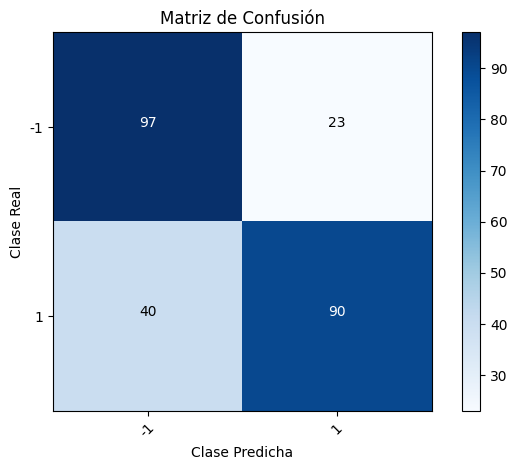

0.748
[[97 23]
 [40 90]]
              precision    recall  f1-score   support

          -1       0.71      0.81      0.75       120
           1       0.80      0.69      0.74       130

    accuracy                           0.75       250
   macro avg       0.75      0.75      0.75       250
weighted avg       0.75      0.75      0.75       250



In [92]:
# Crea la figura y los ejes

classes = [-1, 1]  # Clases negativa y positiva

plt.figure()
plt.imshow(confussion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Etiqueta los valores en la matriz
thresh = confussion_matrix.max() / 2.
for i in range(confussion_matrix.shape[0]):
    for j in range(confussion_matrix.shape[1]):
        plt.text(j, i, format(confussion_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confussion_matrix[i, j] > thresh else "black")

plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()


print(accuracy_score(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

In [ ]:
    # def train(self,x,y, epochs):
    #     num_samples, num_caracteristicas = x.shape
    #     self.numero_clases = len(np.unique(y))  
    #     self.w = np.zeros((self.numero_clases, num_caracteristicas))

    #     for i in range(epochs):
    #        for c in range(self.numero_clases):
    #           y_class = (y == c).astype(int)

    #           s=self.S(x,self.w[c])
    #           loss=s-y_class
    #           gradient = np.dot(x.T, loss) / num_samples
    #           self.w[c] -= self.alpha * gradient

    # def predict(self,x):
    #     num_samples= x.shape[0]
    #     y_pred = np.zeros(num_samples, dtype=int)
    #     for i in range(num_samples):
    #          class_probs = [self.S(x[i], self.w[c]) for c in range(self.numero_clases)]
    #          y_pred[i] = np.argmax(class_probs)

In [46]:
# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.Training(X, Y)

# Make predictions
y_pred = model.Testing(X)

# Graph the model
model.Graph(X, Y)

# # Create a linear regression model
# model = LinearRegression()

# # Fit the model to the data
# model.fit(X, Y)

# # Make predictions
# y_pred = model.predict(X)

# # Graph the model
# model.Graph(X, Y)


# print(X.shape)
# print(len(np.unique(Y)))

ValueError: operands could not be broadcast together with shapes (831,) (831,582) (831,) 

In [5]:
import seaborn as sns
import numpy as np
import random
from sklearn.utils import resample
def selectRandomReplace(X, Y, numberOfRegisters):

  bootstrap_X, bootstrap_Y = resample(X, Y, n_samples=numberOfRegisters, replace=True, random_state=None)  # Set random_state for reproducibility

  return bootstrap_X, bootstrap_Y

In [6]:
def makeRandomForest(X, Y, numberOfTrees, numberOfRegisters=10):
  T = []
  for i in range(numberOfTrees):
    xi_train, yi_train = selectRandomReplace(X, Y, numberOfRegisters)
    T.append(DT())
    T[i].fit(xi_train, yi_train)
  return T

In [7]:
Forest = makeRandomForest(X, Y, 10, 832)


In [8]:
def forestPredict(x, forest):
  classes = [t.predict(x) for t in forest]
  unique_elements, element_counts = np.unique(classes, return_counts=True)
  index_of_most_common = np.argmax(element_counts)
  return unique_elements[index_of_most_common]

In [9]:
def forestPredictions(X, forest):
  predictions = []
  for x in X:
    predictions.append([forestPredict(x, forest)])

  return np.array(predictions)


In [10]:
y_comita = forestPredictions(X_test, Forest)

print(y_comita == Y_test)



[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 